# XAUUSD

In [1]:
import quandl
import pandas as pd
import numpy as np

# plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import os

import warnings
import logging

# scikit-learn modules
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

# User defined modules
from column_transformers.technical_indicators import MacdSignal, StochRsiSignal
from column_transformers.dates import DateDummy

In [2]:
xau_ratios = [
    "WGC/GOLD_DAILY_USD"
#     "WGC/GOLD_DAILY_EUR",
#     "WGC/GOLD_DAILY_TRY",
#     "WGC/GOLD_DAILY_JPY",
#     "WGC/GOLD_DAILY_GBP",
#     "WGC/GOLD_DAILY_CAD",
#     "WGC/GOLD_DAILY_CHF",
#     "WGC/GOLD_DAILY_VND",
#     "WGC/GOLD_DAILY_KRW",
#     "WGC/GOLD_DAILY_RUB",
#     "WGC/GOLD_DAILY_AUD",
]

economic_indc = []

### Quandl data terms

Anyone seeking to use this code must first apply for an account with [Quandl](https://www.quandl.com) in order to receive an valid authetitciation key.

In [3]:
DIR_NAME = os.path.abspath(os.path.join(os.getcwd(), '..'))
FILEPATH = os.path.join(DIR_NAME, "auth.txt")

with open(FILEPATH, "r") as f:
    authtoken = f.read();

# Retrieve Data

In [173]:
xau_df_dict = {}

for ratio in tqdm(xau_ratios):
    name = ratio.lower().replace("/", "_")

    # get the ratio dataframe
    df = quandl.get(ratio, authtoken=authtoken, start_date = "1979-01-01")
    df.columns = ["price"]
    
    # check for missing business days 
    if pd.infer_freq(df.index) != "B":
        logging.warn("Datetime frequency is not Business Days")
    
    xau_df_dict[name] = df

100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


## Volatility

In [174]:
annualization_factor = 252.
window_size = [5, 10, 20, 60, 120]

for ratio, df in tqdm(xau_df_dict.items()):
    start_date, end_date = df.index[0], df.index[-1]
    full_range = pd.date_range(start_date, end_date, freq = "B")
    
    if not np.array_equal(df.index, pd.date_range(start_date, end_date, freq="B")):
        logging.warning("\n{} is missing business days".format(ratio))

    for window in window_size:
        df['{}d_market_vol'.format(window)] = np.sqrt(
            (annualization_factor/window) * df['price'].rolling(window).var(ddof=0))

100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


## Quandl Features

In [175]:
features = [
    "FRED/T10Y2Y",
    "RATEINF/INFLATION_USA",
]

In [176]:
for ratio, df in xau_df_dict.items():
    for feature in features:
        col_name = feature.lower().replace('/', '_')
        
        # get quandl features. `end_date` is set to df.index[-1] to match the price data
        data = quandl.get(feature, authtoken=authtoken, start_date = "1979-01-01", end_date = df.index[-1])
        start_date, end_date = data.index[0], data.index[-1]

        # Some features contain missing data. To best simulate how the data would be ingested
        # realtime, the current value is forward filled. This achieved by resampling.
        if not np.array_equal(data.index, pd.date_range(start_date, end_date, freq="B")):
            logging.warning("\n\t{} is missing business days".format(feature))
                    
        df[col_name] = data
    
    df[:] = df.ffill()

	FRED/T10Y2Y is missing business days
	RATEINF/INFLATION_USA is missing business days


## Technical indicator features

In [194]:
import talib

technical_indicators= {
    "MACD" : ("macd", "macdsignal", "macdhist"),
    "STOCHRSI" : ("fastk", "fastd"),
    "MOM" : ("real"),
    "APO" : ('real'),
    "RSI" : ('real')
}

for ratio, df in xau_df_dict.items():
    
    # talib requires market price data. starting price of $1 is taken
    # since absolute values are not important (preprocess scaling)
    price = df['price'].values

    for indicator, indicator_type in technical_indicators.items():
        # Return the result for each indicator
        if indicator == 'STOCHRSI':
            result = getattr(talib, indicator)(price, fastd_matype = 8)
        else:
            result = getattr(talib, indicator)(price)

        if isinstance(result, np.ndarray):
            df[indicator.lower()] = result
        else:
            for f, r in zip(indicator_type, result):
                if f == indicator.lower():
                    df["{}".format(indicator.lower())] = r
                else:
                    df["{}_{}".format(indicator.lower(), f)] = r

## Data preprocessing 

In [195]:
from split._split import TrainValidateTest

data = xau_df_dict['wgc_gold_daily_usd']
data['target'] = data['price'].shift(-1).pct_change()
data.dropna(inplace = True)

X = data.drop(['price', 'target'], axis = 1)
y = (data['target'] > 0).astype(int)
    
split = TrainValidateTest(0.7, 0.15, 0.15)
X_train, X_valid,  X_test, y_train, y_valid,  y_test = split.transform(X, y)


df = data.loc['1980':'1981', ['price', 'macd', 'macd_macdsignal']]

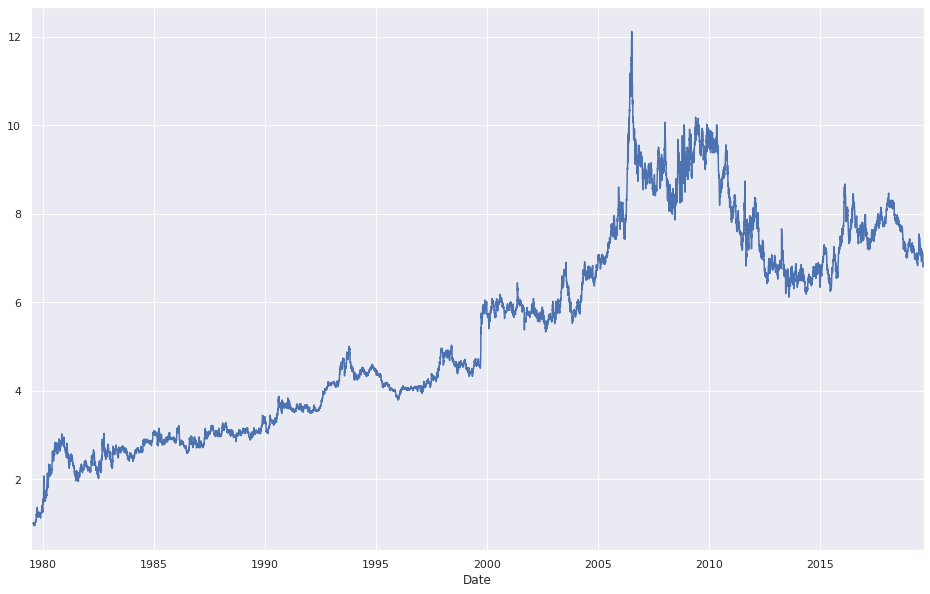

In [268]:
class MacdStrategy():#BaseEstimator, TransformerMixin):

    # ----------------------------------------------------------------------
    # Constructors

    def __init__(self, fast_period=12, slow_period=26, signal_period=9):
        self.fast_period = fast_period
        self.slow_period = slow_period
        self.signal_period = signal_period
        
        
    def __repr__(self):
        return "TBC"
    
    # ----------------------------------------------------------------------
    # strategy statistics/signals
    
    def _macd(self, X):
        
        # calculate MACD oscillator statistics
        price_series = X['price']
        macd, macd_signal, macd_hist = talib.MACD(price_series.values)
        
        return X.assign(
            macd = macd,
            macd_signal = macd_signal,
            macdhist = macd_hist
        )
    
    def _long_signal(self, X):
        self.long = (X['macd'].shift(1) > X['macd_signal'].shift(1))
        #reversal = ((X['macd'].diff().shift(1) > 0) & (df['macd'].diff().shift(2) > 0))
        
        return (self.long) * 1
    
    def _short_signal(self, X):
        self.short = (X['macd'].shift(1) < X['macd_signal'].shift(1)) 
        #reversal = ((df['macd'].diff().shift(1) < 0) & (df['macd'].diff().shift(2) < 0))
                
        return (self.short) * -1
        
        
    # ----------------------------------------------------------------------
    # fit/transform methods
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None, pipeline=True):
        
        # get MACD oscillator statistics
        X = self._macd(X)
        
        # generate strategy long/short signal and asset returns
        long_signal = self._long_signal(X)
        short_signal = self._short_signal(X)
        asset_returns = X['price'].pct_change()
        
        # add strategy return column
        X.loc[:, 'macd_strategy_returns'] = (
            (asset_returns * long_signal) + (asset_returns * short_signal)
        )
        
        if pipeline:
            return X
        else:
            self.X = X
            return self

    # ----------------------------------------------------------------------
    # strategy performance and visualisation
    
    def plot_performance(self, show_long_short = False):
        
        if 'macd_strategy_returns' not in self.X:
            raise KeyError(
                "'X' does not contain 'macd_strategy_returns'. Ensure " 
                "that the 'pipeline' paramter in self.transform() method has "
                "is set to False"
            )
            
        if show_long_short:
            pass
        else:
            cumprod = (1 + self.X['macd_strategy_returns']).cumprod()
            cumprod.plot()
        
        
    #def performance_summary(self)
    
macd = MacdStrategy()
d = macd.transform(xau_df_dict['wgc_gold_daily_usd'], pipeline=False)
d.plot_performance()



0.3379114398472976


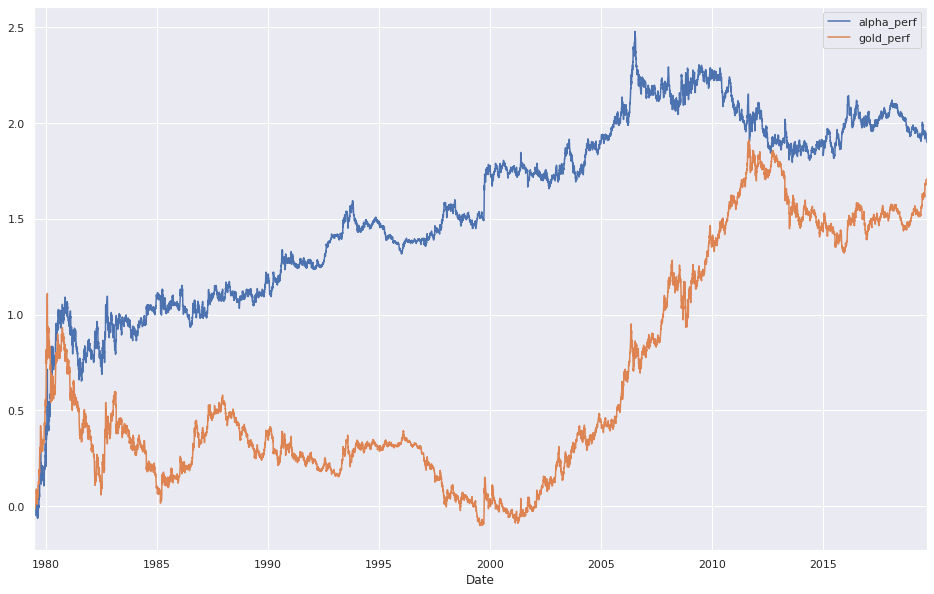

In [212]:
df = data.loc[:, ['price', 'macd', 'macd_macdsignal']]

# Calculate the returns
df['returns'] = df['price'].pct_change()

# long/short periods ignoring lookahead bias
long_biased = df['macd'] >= df['macd_macdsignal']
short_biased = (df['macd'] <= df['macd_macdsignal'])

# Define long entry and exit points
long_entry = (df['macd'].shift(1) > df['macd_macdsignal'].shift(1)) & ((df['macd'].diff().shift(1) > 0) & (df['macd'].diff().shift(2) > 0))
#cross_over_long_exit = (df['macd'] < df['macd_macdsignal']) & (df['macd'].shift(1) > df['macd_macdsignal'].shift(1))
#omentum_long_exit = (df['macd'].diff() >= 0) & (df['macd'].diff().shift(1) <= 0)

# Define short entry and exit points
short_entry = (df['macd'].shift(1) < df['macd_macdsignal'].shift(1)) & ((df['macd'].diff().shift(1) < 0) & (df['macd'].diff().shift(2) < 0))
#cross_over_short_exit = (df['macd'] > df['macd_macdsignal']) & (df['macd'].shift(1) < df['macd_macdsignal'].shift(1))
#momentum_short_exit = (df['macd'].diff() <= 0) & (df['macd'].diff().shift(1) <= 0)

# define simple long/short strategy
df['long'] = (long_entry) * 1 # add exit periods back here
df['short'] = (short_entry) * -1

# long/short periods
longs = df.index[df['long'] == 1]
shorts = df.index[df['short'] == -1]

# start date positions of new long/short positions
long_indices_or_sections = np.arange(longs.size)[longs.to_series().diff() > pd.Timedelta('3D')]
short_indices_or_sections = np.arange(shorts.size)[shorts.to_series().diff() > pd.Timedelta('3D')]

# long/short date regions
long_date_regions = np.split(longs, long_indices_or_sections)
short_date_regions = np.split(shorts, short_indices_or_sections)


df['alpha_return'] = (df['returns'] * df['long']) + (df['returns'] * df['short']) 
df['gold_perf'] =  (1 + df['returns']).cumprod()
df['alpha_perf'] = (1 + df['alpha_return']).cumprod()

#df = df.dropna()

print((np.sqrt(252.) * df['alpha_return'].mean()) / df['alpha_return'].std())

df[['alpha_perf', 'gold_perf']].plot()

In [126]:
macd = ["macd", "macdsignal", "macdhist"]
d = data.copy()

for i in tqdm(range(2, 20)):
    for j in range(4, 30):
        for k in range(3, 10):
            result = talib.MACD(data['price'], fastperiod=i, slowperiod=j, signalperiod=k)
            
            for ind, r in zip(macd, result):
                d['macd_{}_{}_{}_{}'.format(ind, i,j,k)] = r



100%|██████████| 18/18 [02:02<00:00, 11.34s/it]


In [131]:
d = d.dropna()

In [133]:
d.head()

,price,5d_market_vol,10d_market_vol,20d_market_vol,60d_market_vol,120d_market_vol,fred_t10y2y,rateinf_inflation_usa,macd,macd_macdsignal,...,macd_macdhist_19_29_6,macd_macd_19_29_7,macd_macdsignal_19_29_7,macd_macdhist_19_29_7,macd_macd_19_29_8,macd_macdsignal_19_29_8,macd_macdhist_19_29_8,macd_macd_19_29_9,macd_macdsignal_19_29_9,macd_macdhist_19_29_9
Date,,,,,,,,,,,,,,,,,,,,,
1979-08-07,285.10,22.905105,41.726530,25.936725,25.395658,31.921361,-0.31,11.263,0.672332,3.545761,...,-1.050257,1.934828,3.179835,-1.245007,1.934828,3.387589,-1.452761,1.934828,3.595126,-1.660298
1979-08-08,289.00,21.671349,39.880930,26.129025,24.457731,32.063893,-0.32,11.263,0.367396,2.910088,...,-0.914371,1.704965,2.811117,-1.106152,1.704965,3.013672,-1.308707,1.704965,3.217094,-1.512129
1979-08-09,297.10,35.143737,35.447824,25.826614,23.674316,32.339104,-0.30,11.263,0.770453,2.482161,...,-0.606301,1.770514,2.550967,-0.780452,1.770514,2.737415,-0.966901,1.770514,2.927778,-1.157264
1979-08-10,303.75,55.544266,33.605587,25.484387,23.066060,32.723893,-0.33,11.263,1.607943,2.307317,...,-0.243841,2.035439,2.422085,-0.386646,2.035439,2.581420,-0.545982,2.035439,2.749310,-0.713871
1979-08-13,298.75,48.014233,32.008191,25.301894,22.536974,32.975866,-0.34,11.263,1.846912,2.215236,...,-0.143957,2.077739,2.335998,-0.258259,2.077739,2.469491,-0.391752,2.077739,2.614996,-0.537257


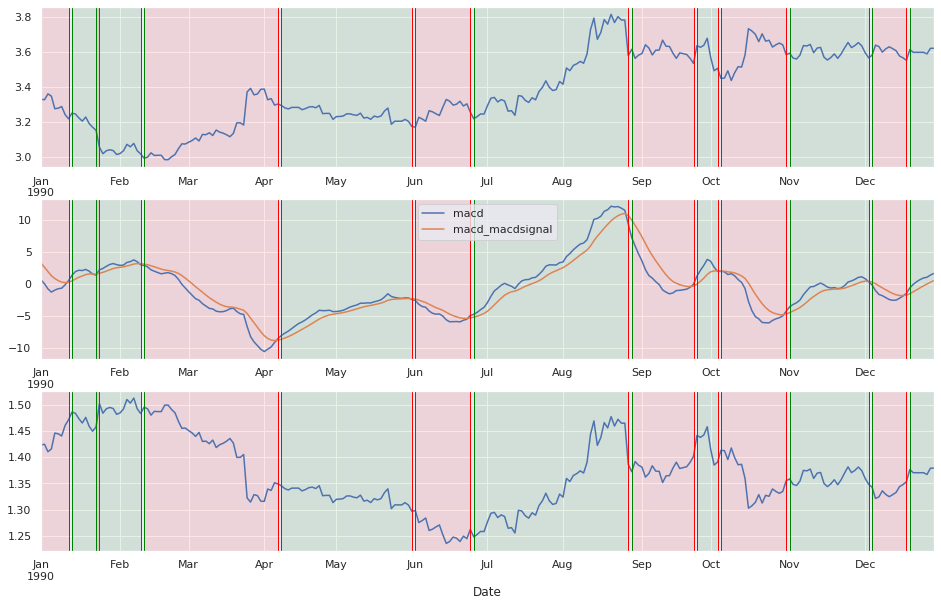

In [211]:
sns.set(rc={'figure.figsize':(16, 10)})
fig, axes = plt.subplots(nrows=3, ncols=1)

df.loc['1990', 'alpha_perf'].plot(ax = axes[0])
df.loc['1990', ['macd', 'macd_macdsignal']].plot(ax=axes[1])
df.loc['1990', 'gold_perf'].plot(ax = axes[2])

for l_period, s_period in zip(long_date_regions, short_date_regions):
    for ax in axes:
        ax.axvline(l_period[0], color='green', linewidth=1)
        ax.axvline(s_period[0], color='green', linewidth=1)
                                             
        ax.axvline(l_period[-1], color='red', linewidth=1)
        ax.axvline(s_period[-1], color='red', linewidth=1)

        ax.axvspan(l_period[0], l_period[-1], alpha = 0.1, color = 'green')
        ax.axvspan(s_period[0], s_period[-1], alpha = 0.1, color = 'red')

In [86]:
df['exit'] = momentum_long_exit


a = df[['macd', 'long']]
a['diff'] = a['macd'].diff()
a['long_entry'] = long_entry

#a['exit'] = (a['macd'].diff() >= 0) & (a['macd'].diff().shift(1) <= 0)
a['1980-01':'1980-06']

/home/joepy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/joepy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,macd,long,diff,long_entry
Date,,,,
1980-01-01,23.675939,1,0.967810,True
1980-01-02,27.953557,1,4.277619,True
1980-01-03,36.929429,1,8.975871,True
1980-01-04,39.871443,1,2.942014,True
1980-01-07,45.351694,1,5.480251,True
1980-01-08,47.253865,1,1.902172,True
1980-01-09,47.982303,1,0.728438,True
1980-01-10,47.659201,1,-0.323102,True
1980-01-11,48.470342,0,0.811140,False


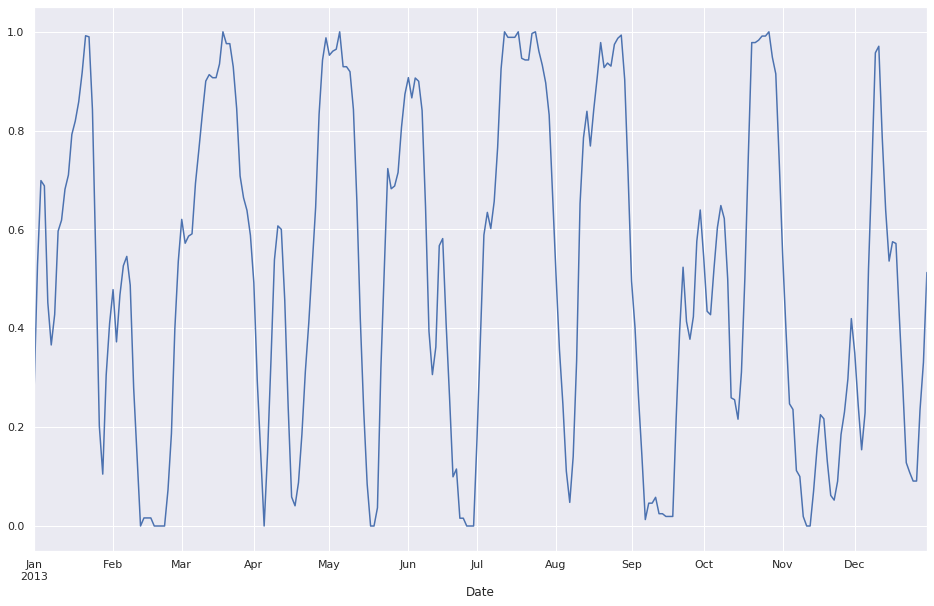

In [210]:
df = data[['price','rsi']]  

df.head()

#df.loc['2013-05':'2013-09', 'rsi'].plot()

rsi_min = df['rsi'].rolling(14).min()
rsi_max = df['rsi'].rolling(14).max()

((df['rsi'] - rsi_min) / (rsi_max - rsi_min)).rolling(3).mean()['2013'].plot()

In [141]:
preprocess_pipeline = Pipeline([
     ('macd_ud_signal', MacdSignal()),
     ('stoch_ud_signal', StochRsiSignal()),
     #('date', DateDummy('weekday_name', 'month_name')),
     #('vol_diff', VolatilityDiff()),
     #('scalar', StandardScaler())
])

X_train_trans, X_valid_trans= (
    preprocess_pipeline.fit_transform(X_train),
    preprocess_pipeline.transform(X_valid)
)

X_train_trans.head()

,5d_market_vol,10d_market_vol,20d_market_vol,60d_market_vol,120d_market_vol,fred_t10y2y,rateinf_inflation_usa,macd,macd_macdsignal,macd_macdhist,stochrsi_fastk,stochrsi_fastd,mom,apo,macd_trend_signal,macd_uptrend,stoch_fastd_buy,stoch_fastd_sell
Date,,,,,,,,,,,,,,,,,,
1979-06-19,9.634139,9.110536,17.836272,32.920258,22.697861,-0.29,10.853,6.192737,6.851541,-0.658804,64.476667,31.825517,5.55,6.866667,0.0,0,0,0
1979-06-20,8.124275,9.690474,16.107627,33.535560,22.858669,-0.31,10.853,6.063373,6.693907,-0.630535,93.094623,52.523763,1.35,6.576603,0.0,0,0,0
1979-06-21,10.259403,9.228436,13.480030,34.066327,23.109868,-0.32,10.853,5.968704,6.548867,-0.580162,100.000000,85.857097,6.25,6.213462,0.0,0,0,0
1979-06-22,13.195145,10.781701,13.413052,34.548858,23.408093,-0.29,10.853,5.918252,6.422744,-0.504491,100.000000,97.698208,3.45,5.475962,0.0,0,0,0
1979-06-25,9.318755,11.759357,13.057494,34.969080,23.649610,-0.27,10.853,5.843189,6.306833,-0.463644,100.000000,100.000000,1.50,5.070192,0.0,0,0,0


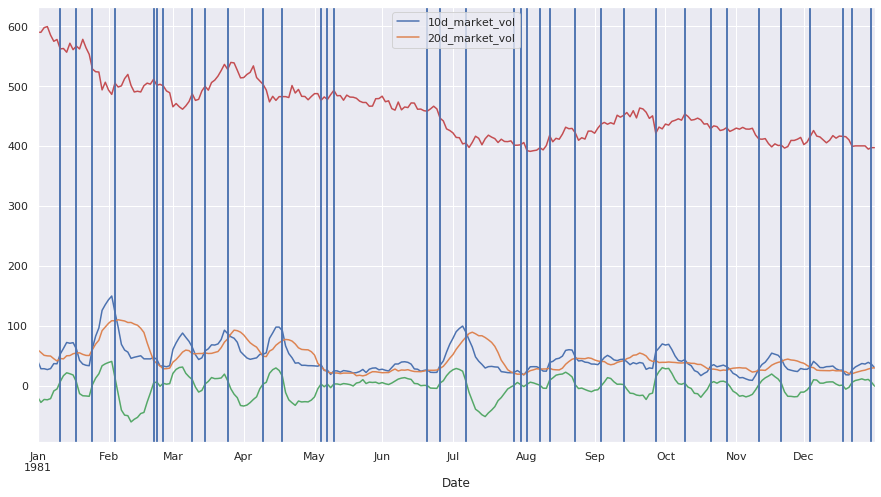

In [61]:
sns.set(rc={'figure.figsize':(15, 8)})
df = X_train.loc['1981', ['10d_market_vol', '20d_market_vol']]

d_20 = df['10d_market_vol']
d_60 = df['20d_market_vol']

df.plot()

dates = (
    (d_20 > d_60) & (d_20.shift(-1) < d_60.shift(-1)) |
    (d_20 > d_60) & (d_20.shift(1) < d_60.shift(1))
)

for date in d_20.index[dates]:
    plt.axvline(date)
    difference = (d_20 -d_60)

difference.index[(difference < 0) & (difference.shift(-1) > 0)]
difference.plot()

xau_df_dict['wgc_gold_daily_usd'].loc['1981', 'price'].plot()
for date in d_20.index[dates]:
    plt.axvline(date)

## Model Selection

In [72]:

classifiers = [
    SVC(gamma=2, C=1),
    LogisticRegression(),
    RandomForestClassifier(criterion='entropy', oob_score=True, n_jobs=-1, random_state= 0),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GradientBoostingClassifier(n_estimators=100),
]

In [16]:
results = {}

for clf in tqdm(classifiers, unit='Model') :
    clf.fit(X_train_trans, y_train)
    
    name = str(clf).split('(')[0]
    
    results[name] = {
        "train_score" : clf.score(X_train_trans, y_train),  
        "valid_score" : clf.score(X_valid_trans, y_valid)
    }      
    
results

 17%|█▋        | 1/6 [00:10<00:50, 10.18s/Model]/home/joepy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/joepy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/joepy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/joepy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/joepy/anaconda3/lib/python3.7/site-packages/sklear

{'SVC': {'train_score': 0.9971416904859126, 'valid_score': 0.4872935196950445},
 'LogisticRegression': {'train_score': 0.5515176262420035,
  'valid_score': 0.5209656925031766},
 'RandomForestClassifier': {'train_score': 0.9818973730774466,
  'valid_score': 0.5101651842439644},
 'MLPClassifier': {'train_score': 0.6124948958758677,
  'valid_score': 0.5279542566709021},
 'AdaBoostClassifier': {'train_score': 0.5735674424935348, 'valid_score': 0.5},
 'GradientBoostingClassifier': {'train_score': 0.6518306791887846,
  'valid_score': 0.5279542566709021}}

## Model Evaluation

In [75]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

tscv = TimeSeriesSplit(n_splits = 2)
clf =  RandomForestClassifier(criterion='entropy', oob_score=True, n_jobs=-1, random_state= 0)
rf_param_grid = {
    'max_depth': [25, 30],
    'min_samples_leaf': [10, 15, 16],
    'min_samples_split': [2, 5],
    'n_estimators': [50, 100, 150]
}

search = GridSearchCV(estimator=clf, cv=tscv, param_grid=rf_param_grid)
search.fit(X_train_trans, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=True, random_state=0,
                                   

In [82]:
search.score(X_train_trans, y_train), search.score(X_valid_trans, y_valid)
search.best_params_

{'max_depth': 25,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 50}

In [77]:
train_score

[0.8505512454062882, 0.8510956853137335, 0.85803729413366, 0.8694705321900096]

In [68]:
n_days = X_train.shape[0]
n_features = X_train.shape[1]

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': 15,
    'max_depth' : 25,
     'min_samples_split': 8,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees_l = [75, 100, 150, 300]

In [83]:
train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    
    clf = RandomForestClassifier(**search.best_params_)
    clf.fit(X_train_trans, y_train)
    
    train_score.append(clf.score(X_train_trans, y_train))
    valid_score.append(clf.score(X_valid_trans, y_valid))
    
#     oob_score.append(clf.oob_score_)
#     feature_importances.append(clf.feature_importances_)


Training Models: 100%|██████████| 4/4 [00:03<00:00,  1.00s/Model]

In [84]:
train_score, valid_score


([0.9060841159657003,
  0.8999591670069416,
  0.8988702871920512,
  0.9074452157343134],
 [0.5190597204574333,
  0.5146124523506989,
  0.5336721728081322,
  0.5082592121982211])

ValueError: x and y must have same first dimension, but have shapes (4,) and (0,)

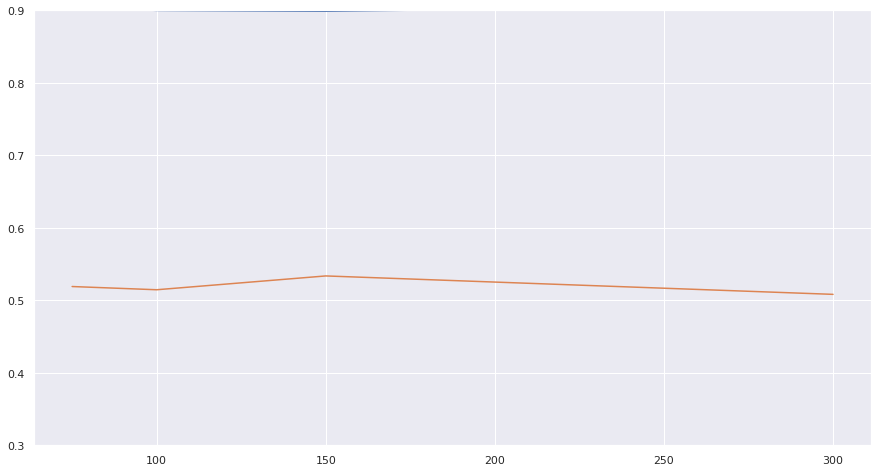

In [86]:
def plot(xs, ys, labels, title='', x_label='', y_label=''):
    for x, y, label in zip(xs, ys, labels):
        plt.ylim((0.3, 0.9))
        plt.plot(x, y, label=label)
        
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
    plt.show()

plot([n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

1.3719429590788785 0.25095780768473114


0.5694454656088777

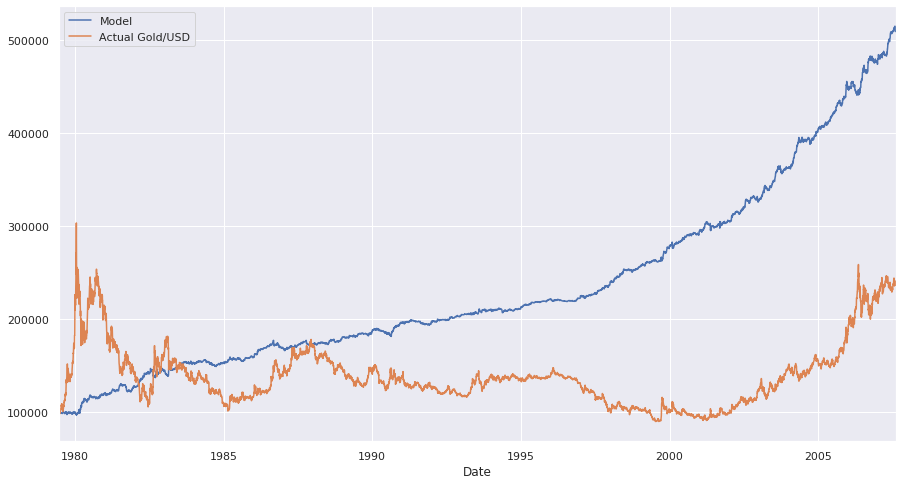

In [102]:
prob_array=[-1,1]
alpha_score = clf.predict_proba(X_train_trans).dot(np.array(prob_array))

# calculate daily returns
alpha_return = alpha_score * data.loc[X_train.index, 'target'].shift(-1) 

xau_usd_return = data.loc[X_train.index, 'target']

# calculate cumulative performance
alpha_perf = 100000 * ((1 + alpha_return).cumprod())
xau_usd_per = 100000 * ((1 + xau_usd_return).cumprod())

#alpha_return.plot()
alpha_sharpe = (np.sqrt(252.) * alpha_return.mean()) / alpha_return.std() 
xau_usd_sharpe = (np.sqrt(252.) * xau_usd_return.mean()) / xau_usd_return.std() 

alpha_perf.plot()
xau_usd_per.plot()

xau_usd_return.mean() / alpha_return.mean() 
sns.set(rc={'figure.figsize':(15, 8)})
plt.legend(labels = ['Model', 'Actual Gold/USD'])


print(alpha_sharpe, xau_usd_sharpe)
alpha_return.std() / xau_usd_return.std()

alpha_perf[-2] ** (252 / alpha_perf.size) - 1 

In [132]:
from sklearn.model_selection import learning_curve
train_sizes=np.linspace(.1, 1.0, 5)
estimator = RandomForestClassifier(**search.best_params_)
cv = TimeSeriesSplit(n_splits = 5)


<module 'matplotlib.pyplot' from '/home/joepy/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

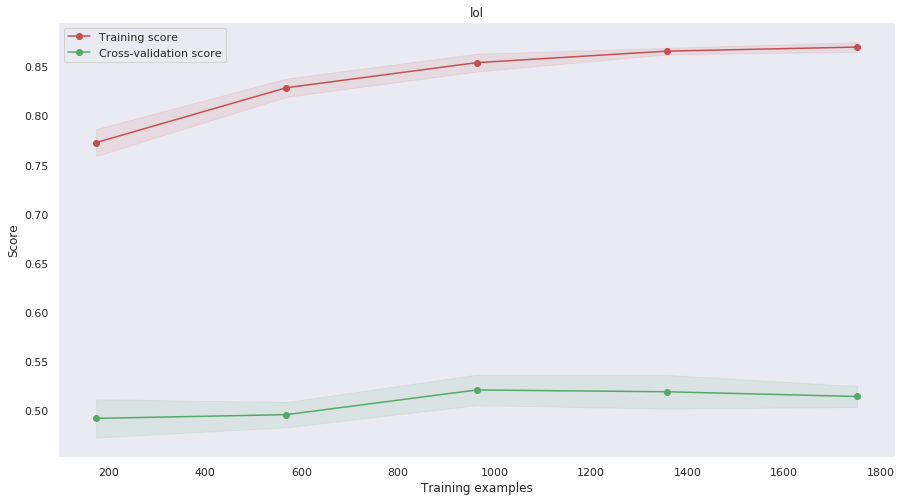

In [133]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(estimator, "lol", X, y, n_jobs =4, cv =cv, train_sizes=train_sizes)

In [127]:
#learning_curve(
        #estimator, X, y, cv=cv, n_jobs=4, train_sizes=train_sizes)
    
cv

TimeSeriesSplit(max_train_size=None, n_splits=20)